<h1 align="center">Deep Learning</h1>
<h4 align="center">Dr. Fatemi Zadeh</h4>
<h4 align="center">Sharif University of Technology, Fall 2024</h4>
<h4 align="center">Practical Assignment 3 </h4>



**Student Name**: Radin Khayyam

**Student ID**: 99101579

---

# **Question 2:**

The goal of this question is to familiarize yourself with different loss criteria and their effects on the training process of a convolutional neural network. Loss functions are functions that define the error of a network and are used to optimize it. These functions are not exclusive to neural networks and are also used in classical methods. Additionally, they are often improved in various aspects. We can also use the combination of several loss functions simultaneously.

To address this question, we use the CIFAR-10 dataset. You can download this dataset using the following link:
CIFAR-10 dataset

The goal of training is to create a classifier for two classes: airplane and automobile from the CIFAR-10 dataset.

---

In [59]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import math
import random

# **Part 1:** Training the Model with Cross-Entropy Loss
Use a simple convolutional neural network (e.g., VGGNet or ResNet-50) that has been pre-trained. We assume these networks include fully connected layers and feature extractors. The network input and output should match the dimensions of the dataset's classes: airplane and automobile from the CIFAR-10 dataset.

Train the model using Cross-Entropy Loss for classifying these two classes.

Plot the Accuracy and Loss curves for each epoch.

Display the Feature Map during the training process for several layers. Feature maps illustrate how model features are extracted and processed in different layers. To do this, select several input samples and visualize the network's outputs at various convolutional layers.

---

In [60]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter for only airplane (0) and automobile (1)
indices_train = [i for i, label in enumerate(trainset.targets) if label == 0 or label == 1]
indices_test = [i for i, label in enumerate(testset.targets) if label == 0 or label == 1]

# Create subsets for train and test
trainset_filtered = Subset(trainset, indices_train)
testset_filtered = Subset(testset, indices_test)

# Split the training data into train and validation sets
train_size = int(0.8 * len(trainset_filtered))
val_size = len(trainset_filtered) - train_size
trainset, valset = torch.utils.data.random_split(trainset_filtered, [train_size, val_size])

# Create data loaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset_filtered, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 32 filters, kernel size 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 64 filters, kernel size 3x3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 128 filters, kernel size 3x3
        
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 4 * 4, 2)  # 128 channels, 4x4 image after pooling

    def forward(self, x):
        # Apply convolutions and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)  # Max pooling with 2x2 kernel
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten and pass through the fully connected layer
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        return x


In [62]:
def train_model(model, trainloader, valloader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(valloader))
        val_accs.append(val_correct / val_total)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, "
              f"Val Loss: {val_loss/len(valloader):.4f}, Val Accuracy: {val_correct/val_total*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs


In [63]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [64]:
def extract_feature_maps(model, input_image):
    layers = [model.conv1, model.conv2, model.conv3]
    feature_maps = []
    x = torch.unsqueeze(input_image, 0)  # Add batch dimension
    for layer in layers:
        x = layer(x)
        feature_maps.append(x)
    return feature_maps

def plot_feature_maps(feature_maps):
    for i, fmap in enumerate(feature_maps):
        num_filters = min(10, fmap.shape[1])  # Limit to 10 filters per layer
        num_rows = math.ceil(num_filters / 5)  # 5 columns per row
        fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
        
        for j in range(num_filters):
            row = j // 5
            col = j % 5
            axes[row, col].imshow(fmap[0, j].cpu().detach().numpy(), cmap='gray')
            axes[row, col].axis('off')
        
        plt.suptitle(f"Feature Maps at Layer {i+1} - 10 Samples", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
        plt.show()

Epoch 1/10, Train Loss: 0.3905, Train Accuracy: 81.58%, Val Loss: 0.2765, Val Accuracy: 88.25%
Epoch 2/10, Train Loss: 0.2028, Train Accuracy: 91.59%, Val Loss: 0.1807, Val Accuracy: 92.55%
Epoch 3/10, Train Loss: 0.1526, Train Accuracy: 93.96%, Val Loss: 0.1517, Val Accuracy: 94.35%
Epoch 4/10, Train Loss: 0.1218, Train Accuracy: 95.29%, Val Loss: 0.1401, Val Accuracy: 94.75%
Epoch 5/10, Train Loss: 0.0978, Train Accuracy: 96.53%, Val Loss: 0.1549, Val Accuracy: 93.90%
Epoch 6/10, Train Loss: 0.0813, Train Accuracy: 96.92%, Val Loss: 0.1237, Val Accuracy: 95.25%
Epoch 7/10, Train Loss: 0.0588, Train Accuracy: 97.85%, Val Loss: 0.1352, Val Accuracy: 95.65%
Epoch 8/10, Train Loss: 0.0595, Train Accuracy: 97.79%, Val Loss: 0.1413, Val Accuracy: 94.85%
Epoch 9/10, Train Loss: 0.0350, Train Accuracy: 98.78%, Val Loss: 0.1391, Val Accuracy: 95.65%
Epoch 10/10, Train Loss: 0.0254, Train Accuracy: 99.19%, Val Loss: 0.1294, Val Accuracy: 95.60%


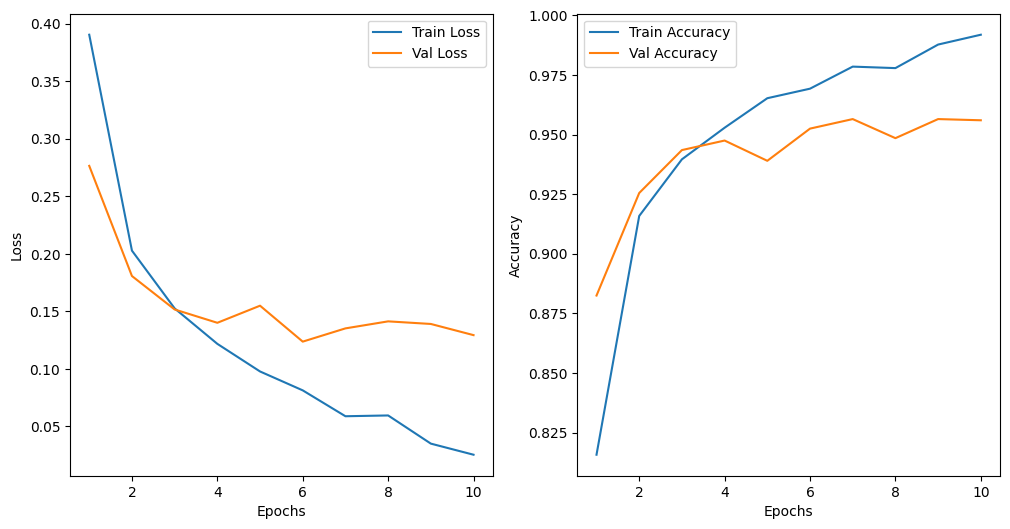

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate model
model_ce = SimpleCNN().to(device)

# Train the model using training and validation sets
train_losses, val_losses, train_accs, val_accs = train_model(model_ce, trainloader, valloader)

# Plot training and validation metrics
plot_metrics(train_losses, val_losses, train_accs, val_accs)

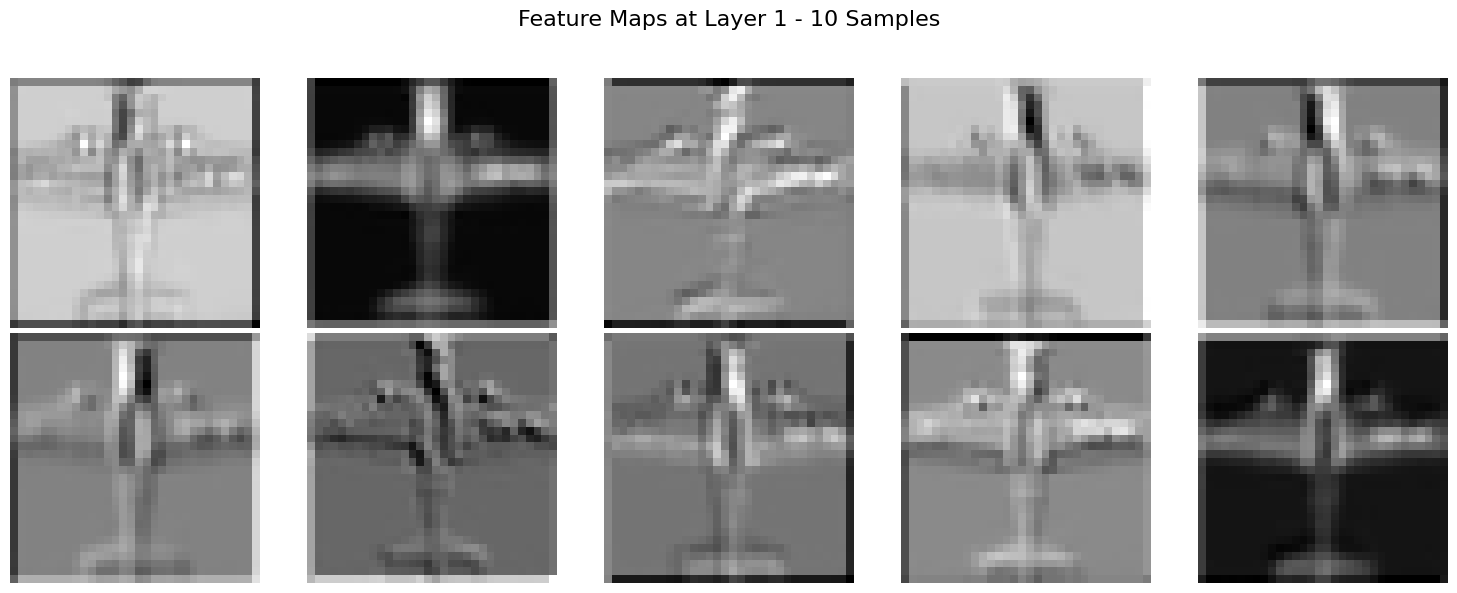

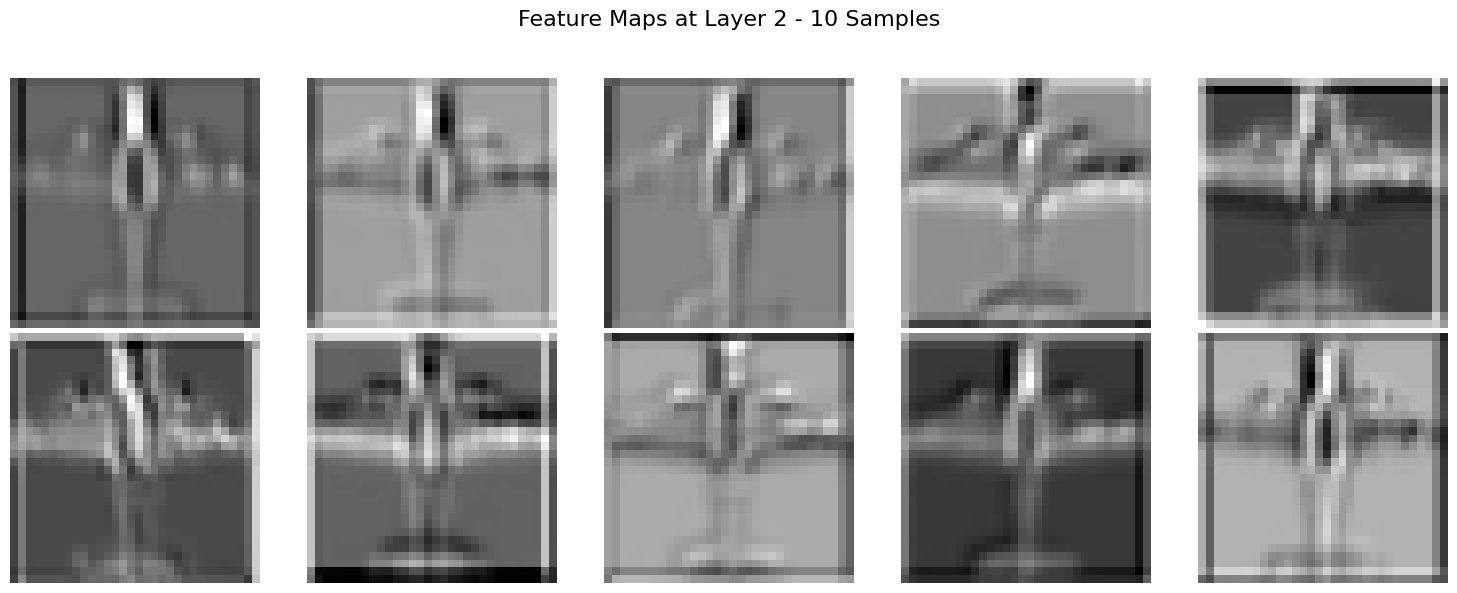

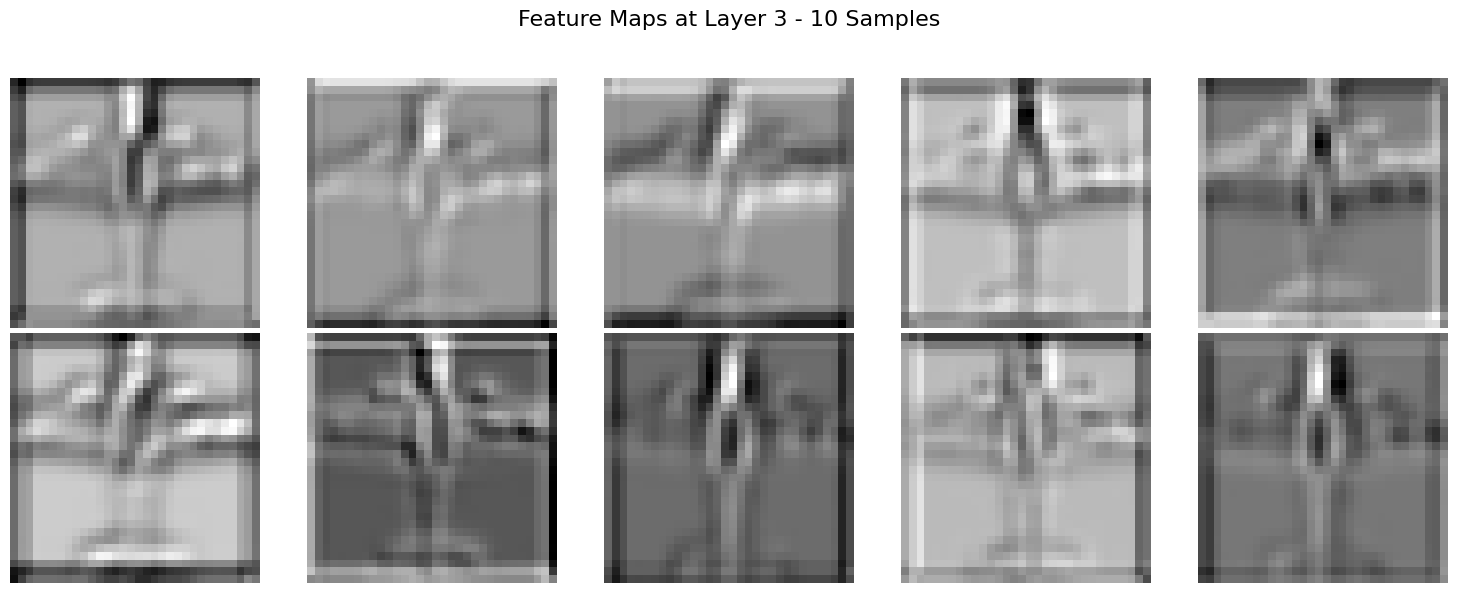

In [68]:
# Extract and plot feature maps from the first input image in the training set
sample_image, _ = trainset[78] # Pick an image from the training subset
sample_image = sample_image.to(device)
feature_maps = extract_feature_maps(model_ce, sample_image)
plot_feature_maps(feature_maps)

# **Part 2:** Training the Model with Triplet Loss

This time, instead of using Cross-Entropy Loss, train the model using Triplet Loss. You can access more details about triplet loss using the following link.

Due to the nature of triplet loss, the dataset related to the classes should be written by yourself.

The purpose of this section is to use triplet loss to train a good feature extractor (note: this section assumes fully connected layers are not included in the training process). After training the data using the feature extractor, you can then fully connect this layer and train it using Cross-Entropy Loss.

Plot the same curves as in Section 1 for this part, including the feature extraction and classification layers. Also, measure the final model's training time based on the number of parameters in the classifier layer.

Examine the changes in Feature Maps across multiple layers and analyze them.

---

In [69]:
# Custom Dataset for Triplet Loss
class TripletDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset
        self.dataset = subset.dataset  # Access the underlying dataset
        self.indices = subset.indices  # Get the indices of the subset
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        anchor_index = self.indices[index]
        anchor, anchor_label = self.dataset[anchor_index]
        
        # Find positive and negative examples
        positive_index = anchor_index
        while True:
            positive_index = self.indices[torch.randint(len(self.indices), (1,)).item()]
            if self.dataset[positive_index][1] == anchor_label:
                break
        
        negative_index = anchor_index
        while True:
            negative_index = self.indices[torch.randint(len(self.indices), (1,)).item()]
            if self.dataset[negative_index][1] != anchor_label:
                break
        
        positive, _ = self.dataset[positive_index]
        negative, _ = self.dataset[negative_index]
        
        return (
            anchor,
            positive,
            negative,
            anchor_label
        )

In [70]:
# Creat the triplet datasets
train_triplet = TripletDataset(trainset)
val_triplet = TripletDataset(valset)

# Create triplet data loaders
trainloader_triplet = DataLoader(train_triplet, batch_size=64, shuffle=True)
valloader_triplet = DataLoader(val_triplet, batch_size=64, shuffle=False)

In [74]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_tr = SimpleCNN().to(device)
feature_extractor = nn.Sequential(*list(model_tr.children())[:-1])  # Remove Fully Connected Layer
for param in feature_extractor.parameters():
    param.requires_grad = True

Epoch 1/10, Train Loss: 1.4967, Val Loss: 1.1067
Epoch 2/10, Train Loss: 1.0461, Val Loss: 1.0246
Epoch 3/10, Train Loss: 0.9697, Val Loss: 1.0015
Epoch 4/10, Train Loss: 0.9244, Val Loss: 0.9285
Epoch 5/10, Train Loss: 0.9069, Val Loss: 0.9043
Epoch 6/10, Train Loss: 0.8897, Val Loss: 0.9157
Epoch 7/10, Train Loss: 0.8967, Val Loss: 0.9091
Epoch 8/10, Train Loss: 0.8895, Val Loss: 0.8783
Epoch 9/10, Train Loss: 0.8705, Val Loss: 0.9110
Epoch 10/10, Train Loss: 0.8741, Val Loss: 0.8588


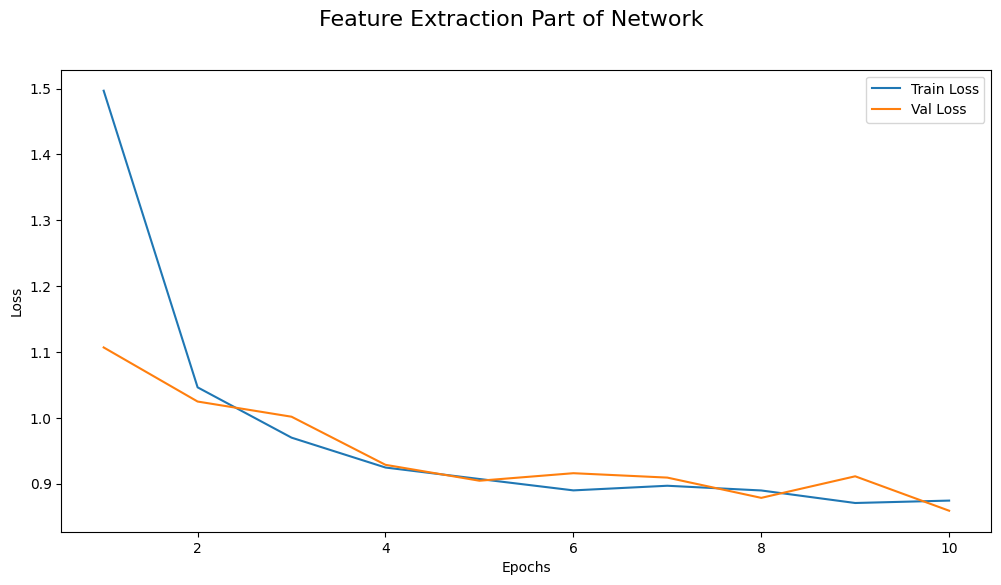

In [75]:
# Train Feature Extractor with Triplet Loss
triplet_loss = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(feature_extractor.parameters(), lr=1e-4)
num_epochs = 10

train_losses, val_losses = [], []
# Training Loop
for epoch in range(num_epochs):
    feature_extractor.train()
    train_loss = 0.0
    for anchor, positive, negative, _ in trainloader_triplet:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_out = feature_extractor(anchor).view(anchor.size(0), -1)
        positive_out = feature_extractor(positive).view(positive.size(0), -1)
        negative_out = feature_extractor(negative).view(negative.size(0), -1)
        loss = triplet_loss(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(trainloader))

    # Validation step
    feature_extractor.eval()
    val_loss = 0.0
    with torch.no_grad():
        for anchor, positive, negative, _ in valloader_triplet:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad()
            anchor_out = feature_extractor(anchor).view(anchor.size(0), -1)
            positive_out = feature_extractor(positive).view(positive.size(0), -1)
            negative_out = feature_extractor(negative).view(negative.size(0), -1)
            loss = triplet_loss(anchor_out, positive_out, negative_out)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(valloader))

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss / len(trainloader):.4f}, "
          f"Val Loss: {val_loss/len(valloader):.4f}")
        

# Loss plot
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.suptitle(f"Feature Extraction Part of Network", fontsize=16)
plt.legend()

Epoch 1/10, Train Loss: 0.6341, Train Accuracy: 72.15%, Val Loss: 0.5810, Val Accuracy: 80.05%
Epoch 2/10, Train Loss: 0.5446, Train Accuracy: 80.19%, Val Loss: 0.5192, Val Accuracy: 80.50%
Epoch 3/10, Train Loss: 0.4937, Train Accuracy: 81.61%, Val Loss: 0.4836, Val Accuracy: 80.75%
Epoch 4/10, Train Loss: 0.4618, Train Accuracy: 82.62%, Val Loss: 0.4597, Val Accuracy: 81.55%
Epoch 5/10, Train Loss: 0.4406, Train Accuracy: 82.44%, Val Loss: 0.4429, Val Accuracy: 81.85%
Epoch 6/10, Train Loss: 0.4233, Train Accuracy: 83.14%, Val Loss: 0.4302, Val Accuracy: 82.00%
Epoch 7/10, Train Loss: 0.4106, Train Accuracy: 83.47%, Val Loss: 0.4210, Val Accuracy: 82.85%
Epoch 8/10, Train Loss: 0.4005, Train Accuracy: 83.55%, Val Loss: 0.4112, Val Accuracy: 82.65%
Epoch 9/10, Train Loss: 0.3907, Train Accuracy: 84.04%, Val Loss: 0.4040, Val Accuracy: 83.10%
Epoch 10/10, Train Loss: 0.3840, Train Accuracy: 84.24%, Val Loss: 0.3974, Val Accuracy: 83.00%


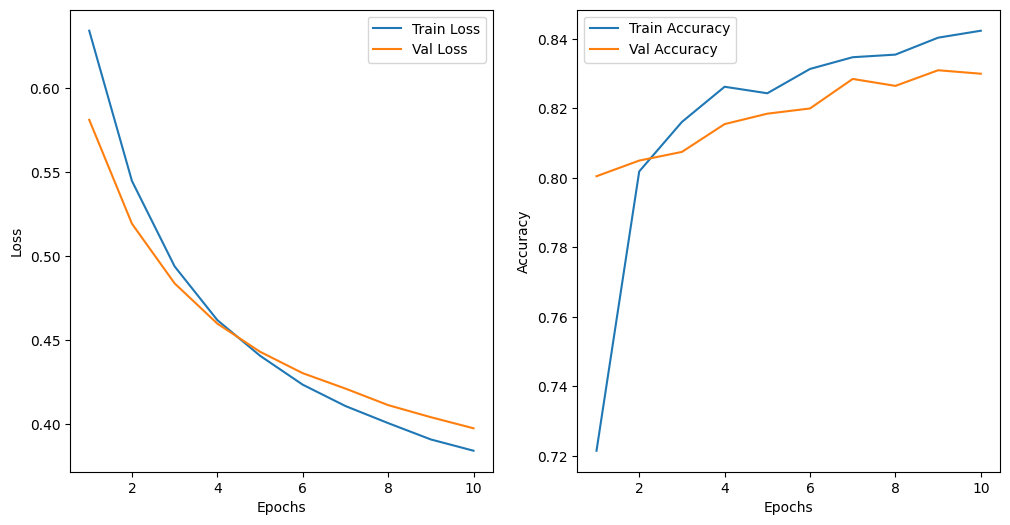

In [77]:
# Freez feature extraction part
for param in feature_extractor.parameters():
    param.requires_grad = False

# Train fully connected layer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tr.parameters(), lr=0.001)
num_epochs = 10

train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model_tr.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_tr(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(trainloader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation step
    model_tr.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_tr(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(valloader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc*100:.2f}%, "
          f"Val Loss: {val_loss/len(valloader):.4f}, Val Accuracy: {val_correct/val_total*100:.2f}%")


plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [81]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_tr(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

accuracy = (test_correct / test_total)*100
print(f"Accuracy on Test Data: {accuracy:.2f}%")

Accuracy on Test Data: 85.55%


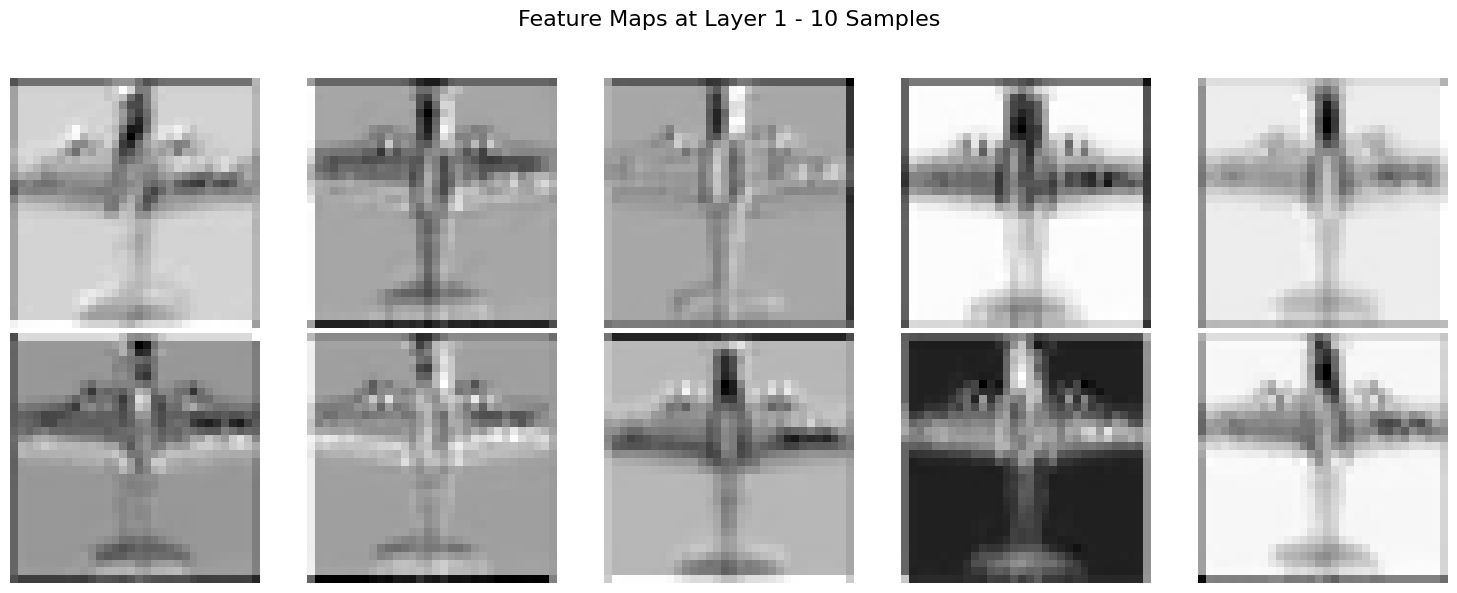

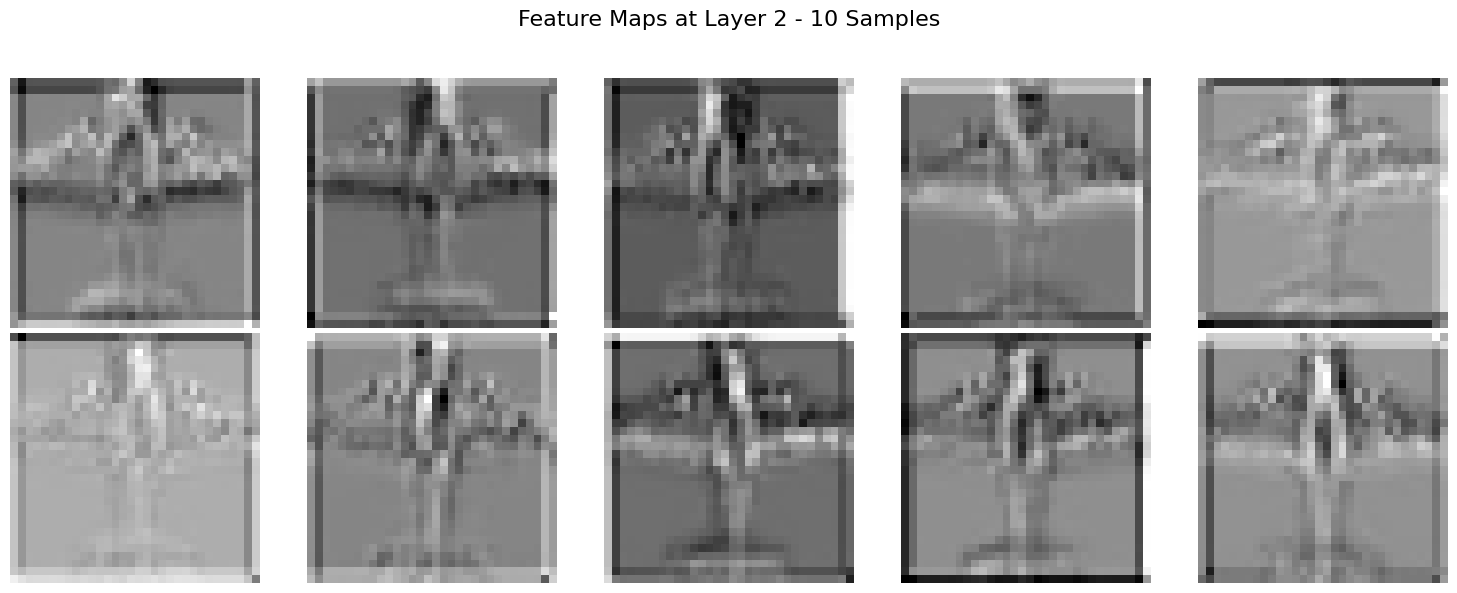

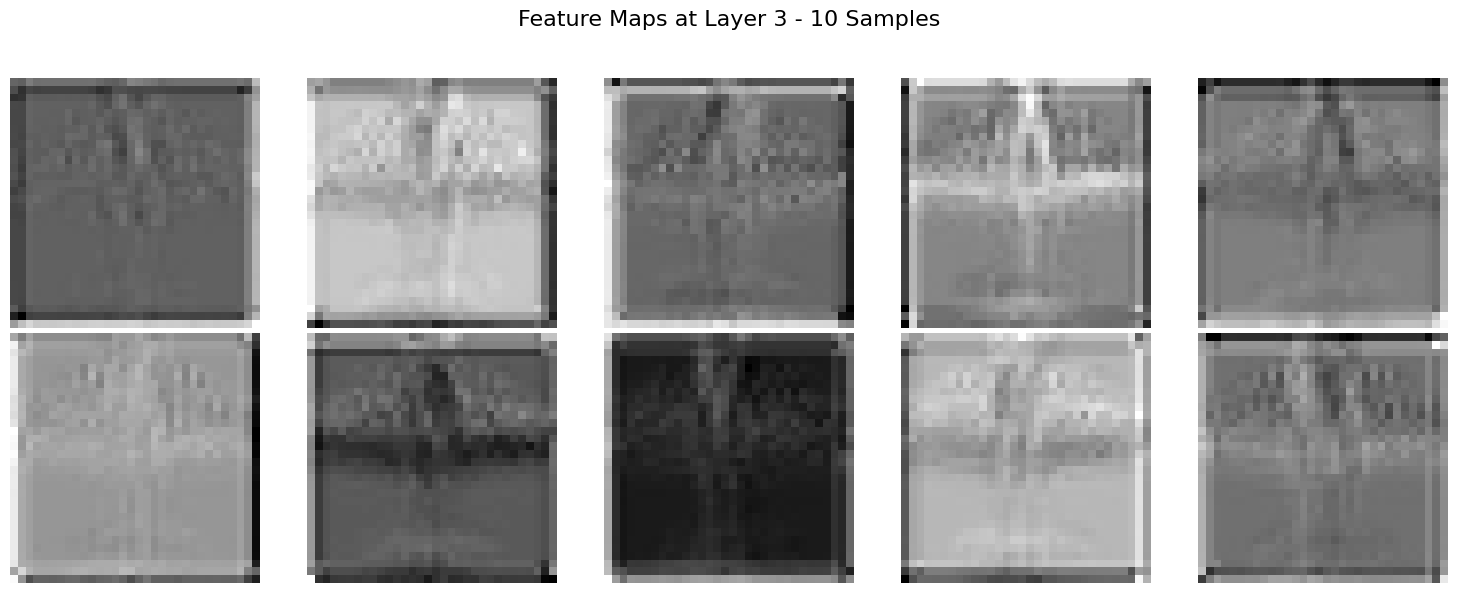

In [83]:
# Extract and plot feature maps from the first input image in the training set
sample_image, _ = trainset[78] # Pick an image from the training subset
sample_image = sample_image.to(device)
feature_maps = extract_feature_maps(model_tr, sample_image)
plot_feature_maps(feature_maps)

# **Part 3: Comparison and Conclusion**
Using two metrics, Triplet Loss and Cross Entropy Loss, at various stages of training a convolutional neural network (CNN), analyze how each of these metrics impacts the model's performance in the following aspects:

* The quality of feature maps across different layers of the network

* The final accuracy of the model on the test dataset

* The convergence speed during the training process

* Finally, conclude which metric is more suitable for various applications, including the ability to generalize to new data, handling complex datasets, and extracting semantic features.

----


**Feature Maps Quality**  
- **Triplet Loss**: Produces semantically rich embeddings, clustering similar features and separating dissimilar ones, ideal for tasks like facial recognition.  
- **Cross Entropy Loss**: Focuses on class separability, yielding less structured embeddings but effective for classification.  

**Final Accuracy**  
- **Triplet Loss**: Relies on embedding quality; performance depends on triplet sampling and distance-based classifiers.  
- **Cross Entropy Loss**: Directly optimizes class-label prediction, generally achieving higher accuracy in standard classification tasks.  

**Convergence Speed**  
- **Triplet Loss**: Slower due to triplet mining complexity and higher computational cost.  
- **Cross Entropy Loss**: Faster convergence with straightforward gradient updates.  

**Conclusion**  
- **Triplet Loss** is ideal for generalization, complex datasets, and embedding-rich tasks (e.g., biometric identification).  
- **Cross Entropy Loss** is better for traditional classification, focusing on accuracy and efficiency.

# **Part 4:**

This time, we aim to use both loss functions in training simultaneously. To do this, consider the following combined loss function:

$$ L_{total} = L_{triplet} + L_{cross-entropy}$$
 
Perform the backpropagation based on $L_{total} $.

* Pay attention to the following points:

* Unlike the previous section, the model first trains to extract feature maps, which are then used by the classifier.

* Plot the requested graphs for this section.

* Calculate the final accuracy of the model on the test dataset.

* Analyze the impact of combining the loss functions in your report.

---

Epoch 1/10, Train Loss: 1.3369, Train Accuracy: 70.74%, Val Loss: 1.0564, Val Accuracy: 81.90%
Epoch 2/10, Train Loss: 0.9117, Train Accuracy: 84.81%, Val Loss: 0.8674, Val Accuracy: 86.75%
Epoch 3/10, Train Loss: 0.7747, Train Accuracy: 88.21%, Val Loss: 0.7826, Val Accuracy: 88.70%
Epoch 4/10, Train Loss: 0.6849, Train Accuracy: 89.25%, Val Loss: 0.7036, Val Accuracy: 89.85%
Epoch 5/10, Train Loss: 0.6151, Train Accuracy: 91.16%, Val Loss: 0.6618, Val Accuracy: 90.70%
Epoch 6/10, Train Loss: 0.5791, Train Accuracy: 92.21%, Val Loss: 0.6116, Val Accuracy: 91.40%
Epoch 7/10, Train Loss: 0.5316, Train Accuracy: 92.34%, Val Loss: 0.5926, Val Accuracy: 91.70%
Epoch 8/10, Train Loss: 0.4898, Train Accuracy: 93.53%, Val Loss: 0.5454, Val Accuracy: 92.30%
Epoch 9/10, Train Loss: 0.4563, Train Accuracy: 93.71%, Val Loss: 0.5373, Val Accuracy: 93.15%
Epoch 10/10, Train Loss: 0.4340, Train Accuracy: 94.11%, Val Loss: 0.5195, Val Accuracy: 92.70%


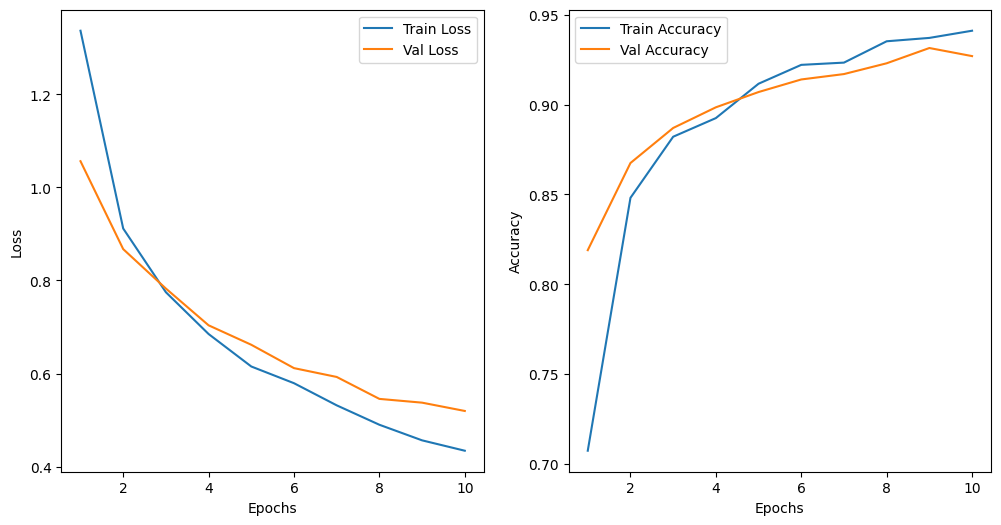

In [91]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_tr_ce = SimpleCNN().to(device)

# Train Feature Extractor with Triplet Loss + Cross_Entropy Loss
triplet_loss = nn.TripletMarginLoss(margin=1.0)
cross_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_tr_ce.parameters(), lr=1e-4)
num_epochs = 10

train_losses, val_losses, train_accs, val_accs = [], [], [], []
# Training Loop
for epoch in range(num_epochs):
    # Training Step
    model_tr_ce.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for anchor, positive, negative, labels in trainloader_triplet:
        anchor, positive, negative, labels = anchor.to(device), positive.to(device), negative.to(device), labels.to(device)
        optimizer.zero_grad()
        anchor_out = model_tr_ce(anchor)
        positive_out = model_tr_ce(positive)
        negative_out = model_tr_ce(negative)
        
        loss = triplet_loss(anchor_out, positive_out, negative_out) + cross_loss(anchor_out, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(anchor_out, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_losses.append(train_loss / len(trainloader))
    train_accs.append(train_correct / train_total)

    # Validation step
    model_tr_ce.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for anchor, positive, negative, labels in valloader_triplet:
            anchor, positive, negative, labels = anchor.to(device), positive.to(device), negative.to(device), labels.to(device)
            optimizer.zero_grad()
            anchor_out = model_tr_ce(anchor)
            positive_out = model_tr_ce(positive)
            negative_out = model_tr_ce(negative)
            loss = triplet_loss(anchor_out, positive_out, negative_out) + cross_loss(anchor_out, labels)
            val_loss += loss.item()
            _, predicted = torch.max(anchor_out, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(valloader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss / len(trainloader):.4f}, Train Accuracy: {train_correct/train_total*100:.2f}%, "
          f"Val Loss: {val_loss/len(valloader):.4f}, Val Accuracy: {val_correct/val_total*100:.2f}%")

# Plot training and validation metrics
plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [94]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_tr_ce(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

accuracy = (test_correct / test_total)*100
print(f"Accuracy on Test Data: {accuracy:.2f}%")

Accuracy on Test Data: 93.15%


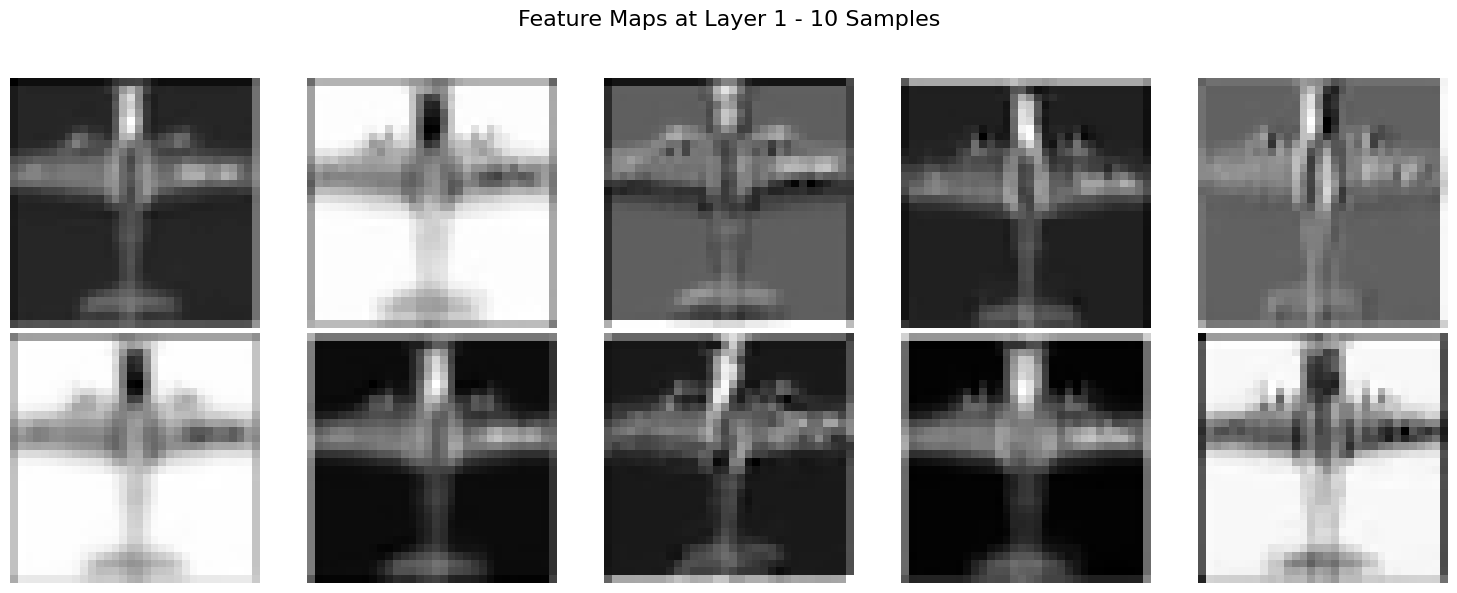

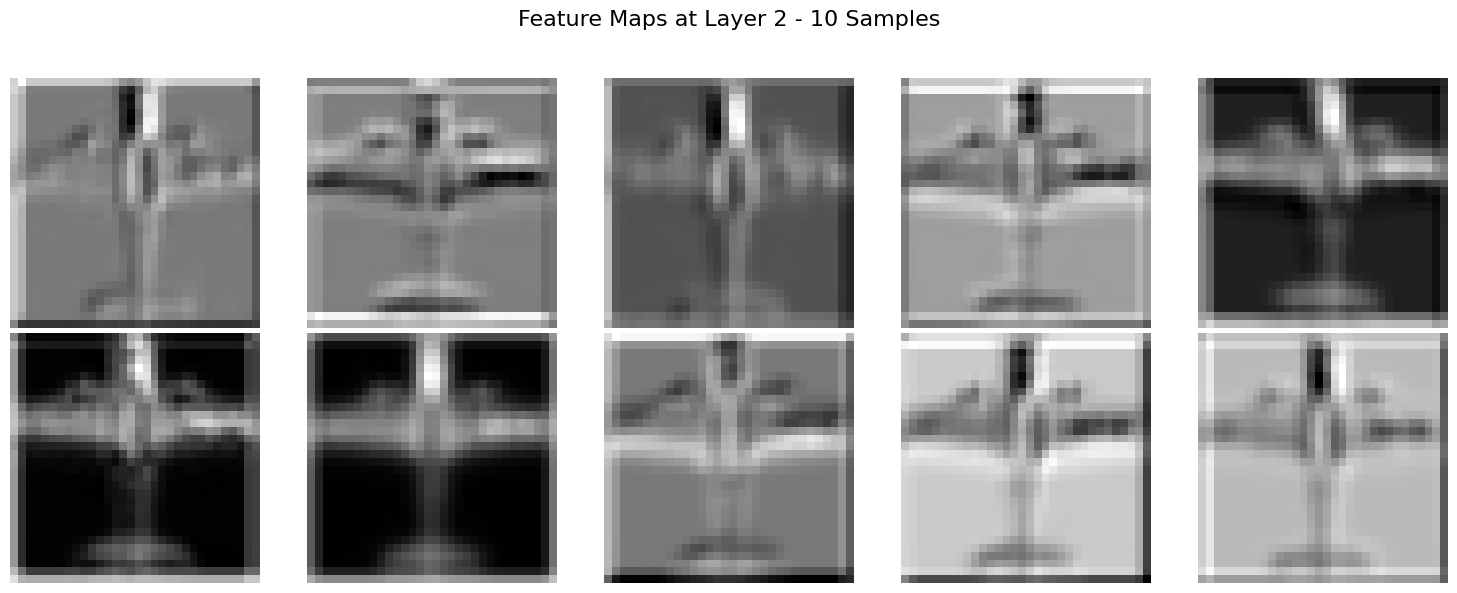

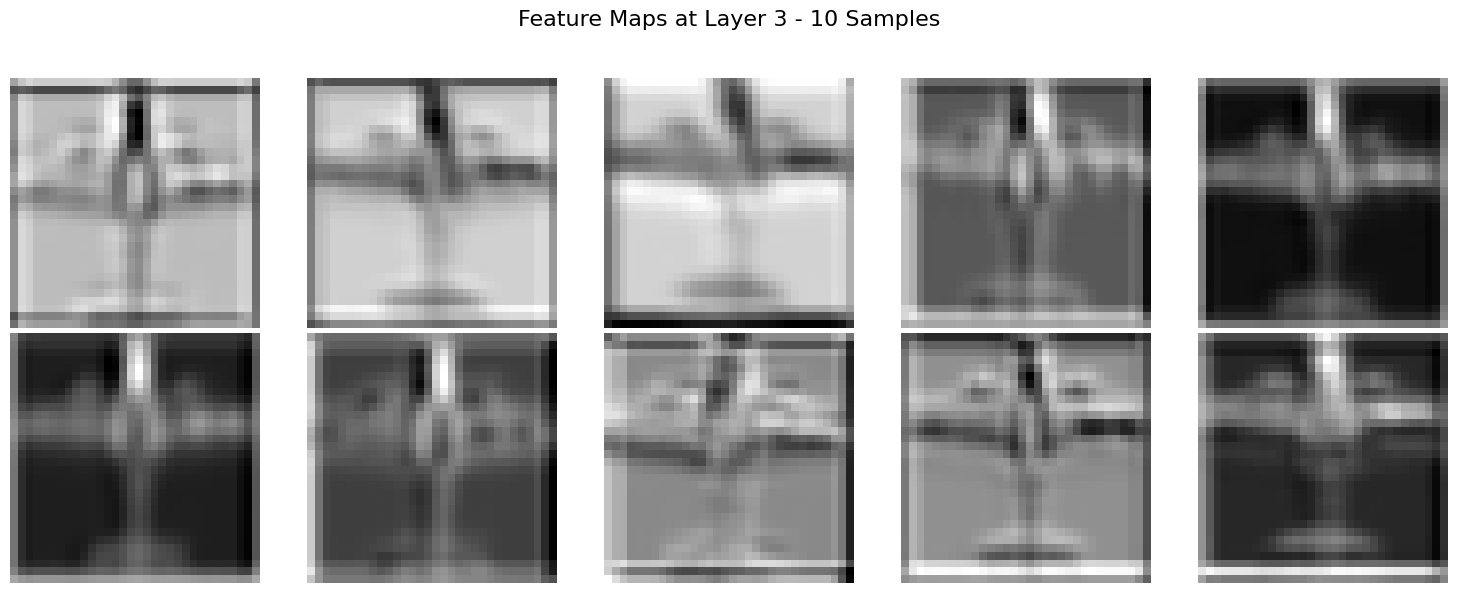

In [97]:
# Extract and plot feature maps from the first input image in the training set
sample_image, _ = trainset[78] # Pick an image from the training subset
sample_image = sample_image.to(device)
feature_maps = extract_feature_maps(model_tr_ce, sample_image)
plot_feature_maps(feature_maps)


**Feature map quality:** Triplet Loss ensures that the feature space preserves semantic relationships, clustering similar samples and separating dissimilar ones effectively.

**Classification accuracy:** Cross Entropy Loss directly optimizes the class predictions, ensuring high performance on the test dataset.


**Training Dynamics:**

The network initially focuses on learning robust feature maps (guided by Triplet Loss).
These feature maps are subsequently refined and leveraged by the classifier (optimized by Cross Entropy Loss).

**Improved Performance:**

Combining these loss functions allows the model to excel in both embedding quality and classification, outperforming models trained with either loss function alone.

This synergy leads to better generalization and accuracy on the test dataset.

**Convergence:**

While adding Triplet Loss may slightly slow down the initial convergence compared to using Cross Entropy Loss alone, the combined approach leads to a better overall solution.

**Evaluation Metrics:**

Graphs of training loss, feature embedding distribution, and test accuracy reflect the enhanced training dynamics and performance. The final test accuracy shows improvement compared to the separate use of either loss function.


**In conclusion, The combined loss function improves the model's ability to extract meaningful features while maintaining strong classification performance. This dual optimization is particularly beneficial for tasks requiring both accurate predictions and well-structured feature embeddings.**